In [112]:
import warnings
warnings.filterwarnings('ignore')

<Axes: title={'center': 'lissage grossier (Pour éviter les trous -> topojs.topology).'}>

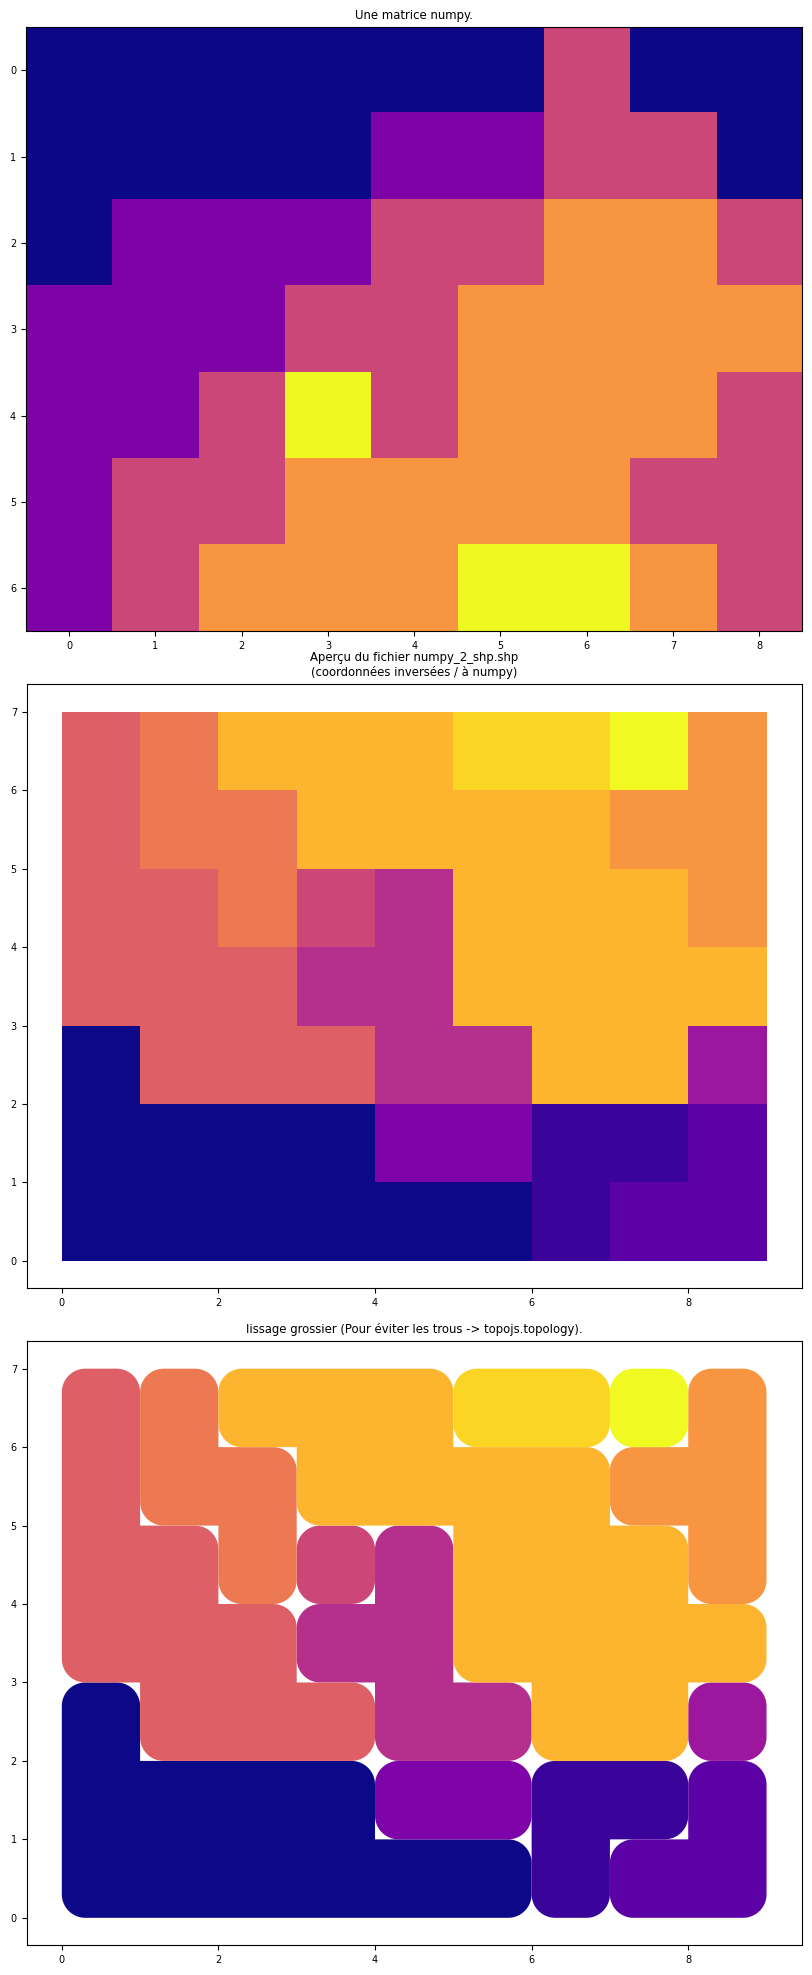

In [116]:
# 1- Exemple minimal : on s'affranchit de la gestion de coordonnées du fichier vecteur...

import matplotlib.pyplot as plt
import numpy as np

from shapely.geometry import Polygon, MultiPolygon, mapping
from rasterio.features import shapes
import fiona
from fiona.crs import from_epsg

import geopandas as gp

# epsg
epsg = 4326

# Un array avec des motifs à trous.
l1 = [
    [1,1,1,1,1,1,3,1,1],
    [1,1,1,1,2,2,3,3,1],
    [1,2,2,2,3,3,4,4,3],
    [2,2,2,3,3,4,4,4,4],
    [2,2,3,5,3,4,4,4,3],
    [2,3,3,4,4,4,4,3,3],
    [2,3,4,4,4,5,5,4,3],
]

nd_arr = np.array(l1)

## DEBUT Gestion affichage
fig, axs = plt.subplots(3)
plt.rcParams["figure.figsize"] = (30,20)
plt.rcParams.update({'font.size': 7})
fig.tight_layout(pad=3.0)
axs[0].set_title('Une matrice numpy.')
axs[0].imshow(nd_arr, cmap='plasma')
## FIN Gestion affichage

schema = {
    'geometry': 'Polygon',
    'properties': {
        'val': 'int'
    }
}
out_shp = '_files/numpy_2_shp.shp'

with fiona.open(out_shp, 'w', crs=from_epsg(4326), driver='ESRI Shapefile', schema=schema) as output:
    for sh in shapes(nd_arr):
        p, val = sh[0]['coordinates'][0], int(sh[1]) 
        poly = Polygon(p)
        output.write({'geometry': mapping(poly), 'properties': {'val': val}})

axs[1].set_title(f'Aperçu du fichier {out_shp.split("/")[1]}\n(coordonnées inversées / à numpy)')
gp.read_file(out_shp).plot(cmap = 'plasma', ax = axs[1])

# Lissage grossier (en sus : utiliser topojs pour supprimer les trous) :
axs[2].set_title('lissage grossier (Pour éviter les trous -> topojs.topology).')
gp.read_file(out_shp).buffer(-0.3).buffer(0.3).plot(cmap = 'plasma', ax = axs[2])

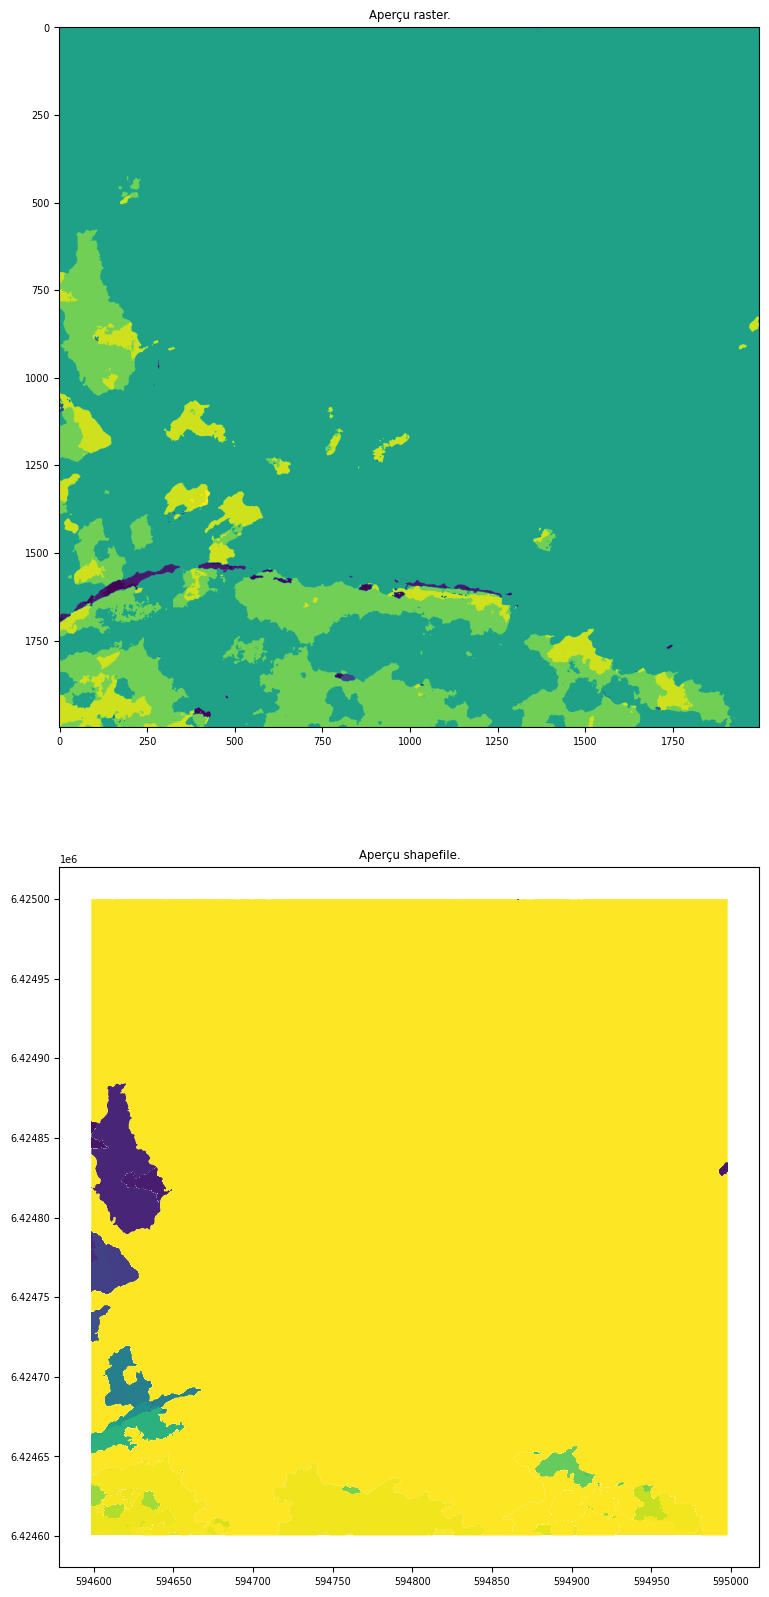

In [117]:
# 2- Conversion à partir de raster

import rasterio as rio
from shapely.geometry import Polygon, MultiPolygon, mapping

rst_f = '_files/1-7967-22978_amax.tif'

with rio.open(rst_f) as src:
    profile = src.profile
    transf = src.transform
    np_in = src.read(1)

    # DEBUT affichage
    fig, axs = plt.subplots(2)
    # plt.rcParams["figure.figsize"] = (50,20)
    axs[0].set_title('Aperçu raster.')
    axs[0].imshow(np_in, cmap='viridis')
    # FIN affichage

    schema = {
        'geometry': 'Polygon',
        'properties': {
            'val': 'int'
        }
    }
    out_shp = '_files/rst_2_shp.shp'

    with fiona.open(out_shp, 'w', crs=from_epsg(2154), driver='ESRI Shapefile', schema=schema) as output:
        for sh in shapes(np_in, transform=transf):
            p, val = sh[0]['coordinates'][0], sh[1]
            poly = Polygon(p)
            output.write({'geometry': mapping(poly), 'properties': {'val': val}})

    # DEBUT affichage
    axs[1].set_title('Aperçu shapefile. (fail ??)')
    gp.read_file(out_shp).plot(cmap = 'viridis', ax = axs[1])
    # FIN affichage

LOCAL_CS["RGF93 / Lambert-93",UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
Solution qui marche :


<Axes: >

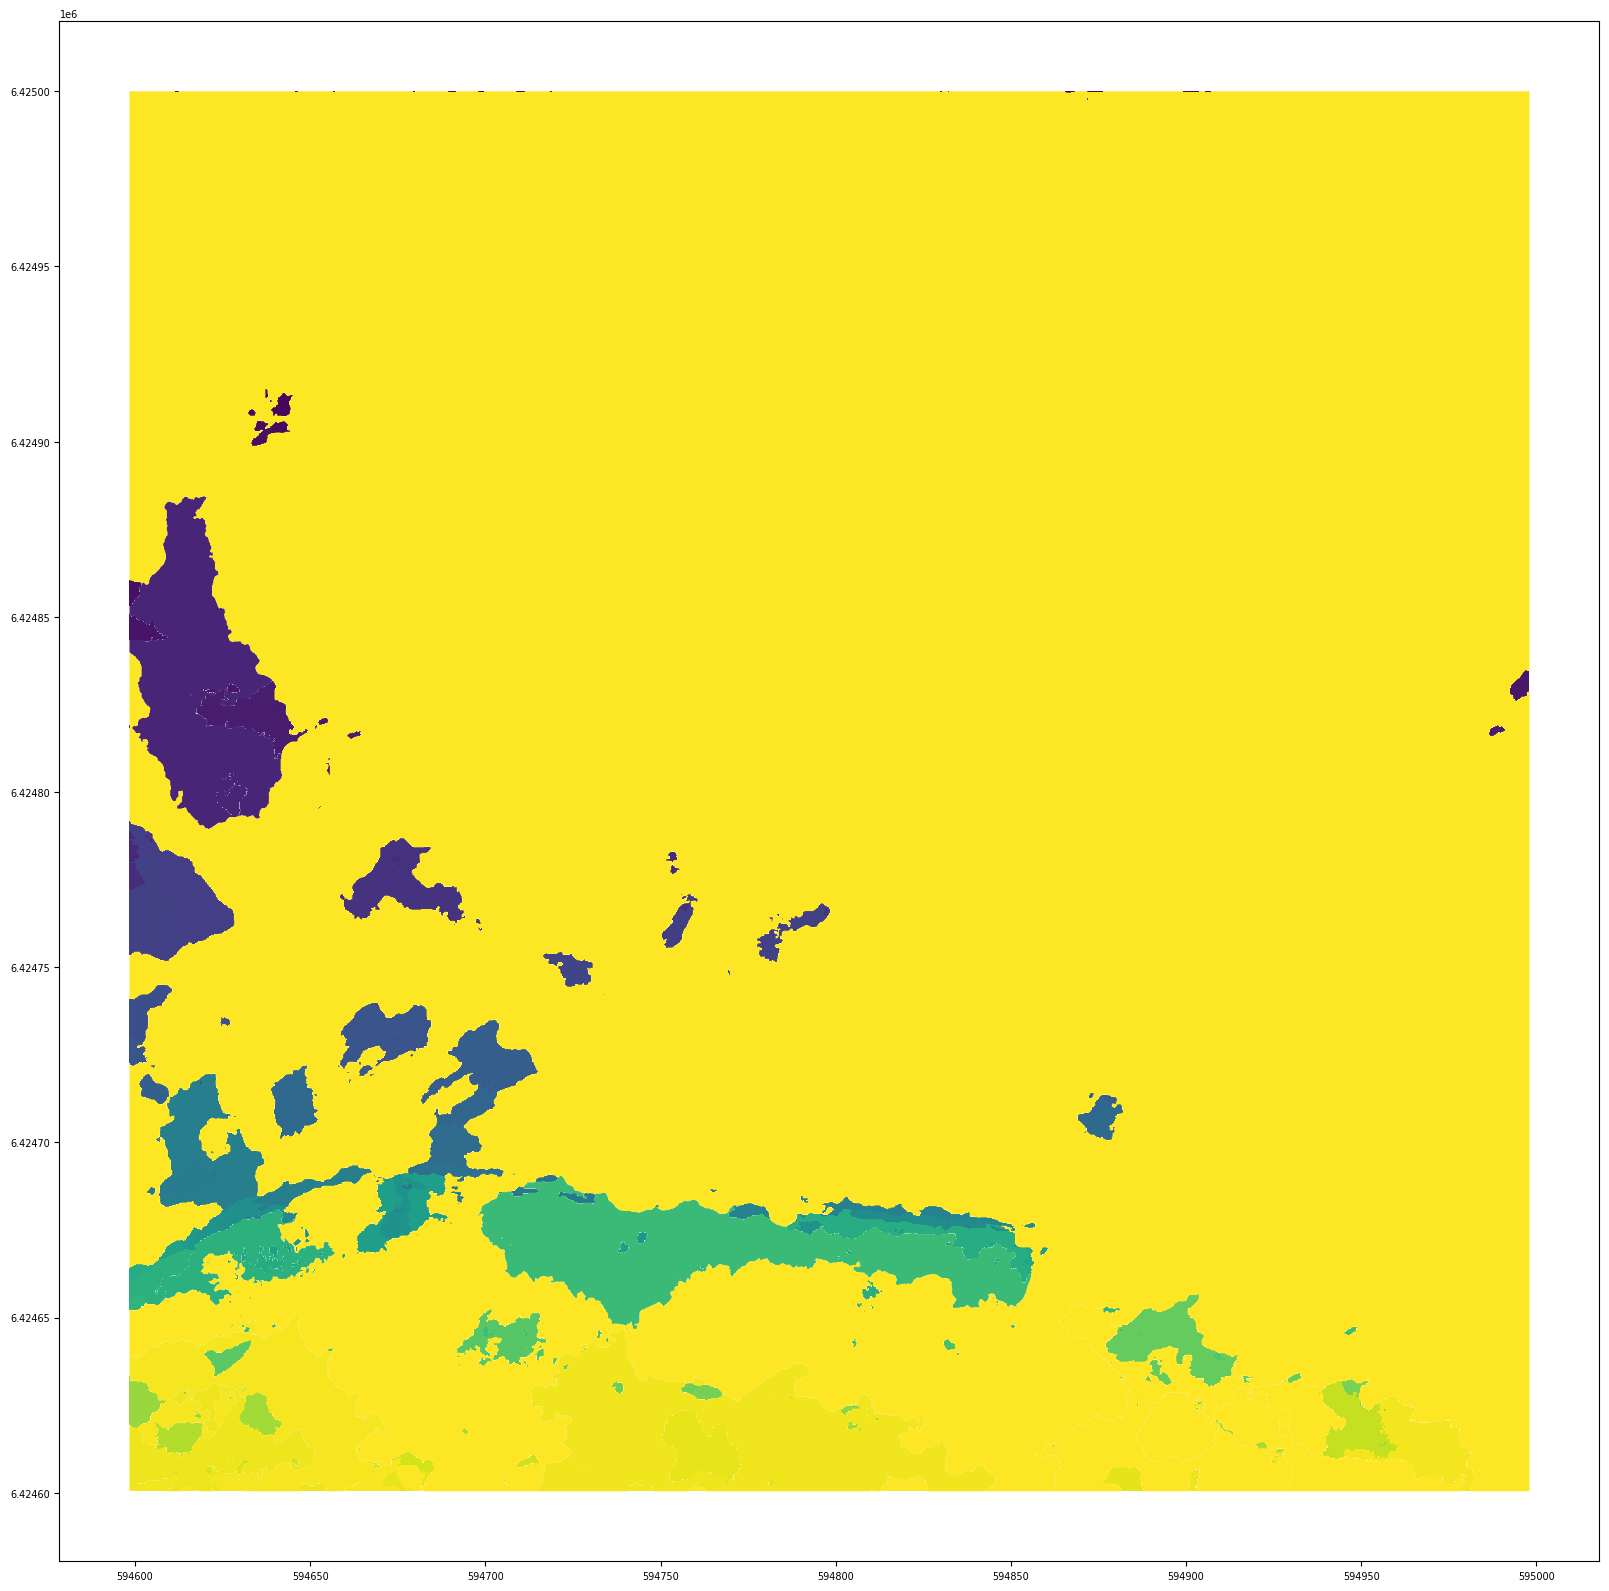

In [122]:
# 3- Vectorisation à la volée

from rasterio.features import shapes
from shapely.geometry import shape

from geopandas import GeoDataFrame

rst_f, out_shp = '_files/1-7967-22978_amax.tif', '_files/rst_2_shp_fly.shp'

with rio.open(rst_f) as src:
    print(src.crs)
    data = src.read(1)
    shape_gen = ((shape(s), v) for s, v in shapes(data, transform=src.transform))
    gdf = GeoDataFrame(dict(zip(["geometry", "class"], zip(*shape_gen))), crs=src.crs)
    gdf.to_file(out_shp)

print('Solution qui marche :')
gp.read_file(out_shp).plot(cmap = 'viridis')